In [21]:
# imports

from scipy.stats import pearsonr
from matplotlib.lines import Line2D
import plotly.graph_objects as go
import plotly.io as pio
import warnings
import numpy as np
import pandas as pd
import power_laws
import seaborn as sns
from matplotlib import pyplot as plt

warnings.filterwarnings('ignore')

%matplotlib notebook

In [54]:
# Functions

def create_radar_plot(position, KmVmaxData):

    #df for the 19 mutants at this position, then with dropped na
    selectedMutations = KmVmaxData[KmVmaxData['position'] == position]
    plotSelectedMutations = selectedMutations[['Km_median','position','WTresidue','residue']].dropna()
    # Using query() method to filter the DataFrame and then reindex to include NaN for missing residues
    filtered_df = plotSelectedMutations.query('residue in @aa_dict').set_index('residue').reindex(aa_dict)


    # Getting the Km_median values for the selected residues
    selected_kmco2_logfit = filtered_df['Km_median']
    WT_residue = plotSelectedMutations['WTresidue'].iloc[0]
    selected_kmco2_logfit[WT_residue] = .149
    normalized_kmco2_logfit = selected_kmco2_logfit / .149
    
    # Log transform and reduce values for positive values so that things scale asymmetrically:
    logNormed = np.log2(normalized_kmco2_logfit)
    for aa in logNormed.keys():
        if logNormed[aa] > 0:
            # Scale down positive deviations 4x
            logNormed[aa] = logNormed[aa]/4          

    fig = go.Figure(go.Barpolar(
        r=logNormed,#np.log2(normalized_kmco2_logfit),
        theta=aa_dict, 
        marker_color=aa_color,
        marker_line_color="black",
        marker_line_width=0,
        opacity=1
    ))

    fig.update_layout(
        template=None,
        polar = dict(radialaxis_angle = aa_label_dict[WT_residue],
                     # Now -1 is 1/2 the WT Km and +0.25 is 2x the WT Km
        radialaxis = dict(range=[-0.5, 0.75], tickvals=[-0.25,0,0.25, 0.5, 0.75],
                          ticks='', showticklabels=False),
        angularaxis = dict(showticklabels=True, ticks='', tickfont=dict(size=12)), 
        ),
        
        width=300,
        height=300,
        paper_bgcolor='rgba(0,0,0,0)',
        title={
            'text': str(WT_residue) + str(position),
            'y': 0.77,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': {'size': 12}
        }
    )
    # Export the figure as a PDF
    file_name = OUTPUT_FIGURE_PATH + f"radar_Km_{position}.svg"
    pio.write_image(fig, file_name, format='svg', scale=3,  engine="kaleido")
    
    # Display the figure in the notebook
    pio.show(fig, validate=False)


def load_rubisco_data(fname):
	"""Convencience function to load the Rubisco data.

	Loads the merged and filtered dataset - this file should already be 
	filtered so that it contains no measurements of mutants etc.
	Note that we hardcode the name of the dataset file for convenience.

	Returns:
		raw_df, kin_df where raw is all the data and kin_df is the filtered data.
	"""
	# Load the data from Excel, remove data points that are not comparable.
	raw_kin_df = pd.read_csv(fname, index_col=0)

	# Filtered DataFrame used for most plots below.
	# Only variants with all the data
	kin_df = raw_kin_df.copy()
	has_KMs = np.logical_and(np.isfinite(kin_df.KC), np.isfinite(kin_df.KO))
	has_kcats = np.logical_and(np.isfinite(kin_df.vO), np.isfinite(kin_df.vO))
	has_kons = np.logical_and(np.isfinite(kin_df.kon_C), np.isfinite(kin_df.kon_O))
	has_all = np.logical_and(np.logical_and(has_KMs, has_kcats), has_kons)
	kin_df = kin_df[has_all]

	return raw_kin_df, kin_df


def filter_data(raw_kin_df):
	"""There are intentionally some duplicates in the raw data because it
	includes Savir data directly copied from some primary references.

	Args:
		raw_kin_df: the full dataset. 

	Returns:
		deduped, savir, nonsavir
	"""
	savir_pmid = '20142476'
	savir_df = raw_kin_df[raw_kin_df.pmid_or_doi == savir_pmid]
	nonsavir_df = raw_kin_df[raw_kin_df.pmid_or_doi != savir_pmid]

	measured_vars = 'KC, vC, S, KO'.split(', ')
	dup_rows = raw_kin_df.duplicated(subset=measured_vars, keep=False)
	dup_df = raw_kin_df[dup_rows]
	savir_dups = dup_df[dup_df.pmid_or_doi == savir_pmid]
	deduped = raw_kin_df.drop(savir_dups.index, axis=0)
	return deduped, savir_df, nonsavir_df


def merge_organisms(kin_df):
	"""Merge organisms by a median filter."""
	# Grouping by species and mutant just in case some of the mutations are not 
	# listed in the species name (they should all be, but mistakes happen). 

	kin_cols = 'KC, vC, S, KO, KRuBP, vO, kon_C, kon_O'.split(', ')
	metadata_cols = ['species', 'mutant', 'isoform', 'taxonomy']
	cols2keep = kin_cols + metadata_cols
	subsset_cols_df = kin_df[cols2keep]
	# Note: median error may not correspond to median value, so we gotta ditch the error values. 
	return subsset_cols_df.groupby(['species', 'mutant', 'isoform', 'taxonomy']).median().reset_index()

In [35]:
# Constant Variables

BOOTSTRAP_DATA = "2024_03_18_bootstrap_update_kH.csv"

KM_BOOTSTRAP_DATA = "2024_01_30_bootstrap_Kms_Vmax.csv"

RESIDUE_TYPE_DATA = "2023_09_20_enrich_for_structure_classes.csv"

RUBISCO_KINETICS_DATA = "" # Waiting for Noam

OUTPUT_FIGURE_PATH = './'

AMINOACID_SEQ = 'MDQSSRYVNLALKEEDLIAGGEHVLCAYIMKPKAGYGYVATAAHFAAESSTGTNVEVCTTDDFTRGVDALVYEVDEARELTKIAYPVALFDRNITDGKAMIASFLTLTMGNNQGMGDVEYAKMHDFYVPEAYRALFDGPSVNISALWKVLGRPEVDGGLVVGTIIKPKLGLRPKPFAEACHAFWLGGDFIKNDEPQGNQPFAPLRDTIALVADAMRRAQDETGEAKLFSANITADDPFEIIARGEYVLETFGENASHVALLVDGYVAGAAAITTARRRFPDNFLHYHRAGHGAVTSPQSKRGYTAFVHCKMARLQGASGIHTGTMGFGKMEGESSDRAIAYMLTQDEAQGPFYRQSWGGMKACTPIISGGMNALRMPGFFENLGNANVILTAGGGAFGHIDGPVAGARSLRQAWQAWRDGVPVLDYAREHKELARAFESFPGDADQIYPGWRKALGVEDTRSALPA*'

# Use consistent aa order
INDEX_ORDER = ['P', 'W', 'F', 'Y', 'I', 'L', 'M', 'V', 'A', 'G',
               'S', 'T', 'C', 'N', 'Q', 'D', 'E', 'K', 'R', 'H']

# Experimental details
CONDITIONS_KEY = {
    'WT_only'                  : ['NP_11_64_2'],
    't0'                       : ['NP_11_64_9', 'NP_11_64_11', 'NP_11_64_12', 'NP_11_64_13', 'NP_11_64_15'],
    '0.04percent_CO2'          : ['NP_11_66_41'],
    '0.2percent_CO2'           : ['NP_11_66_1',  'NP_11_66_2',  'NP_11_66_3'],
    '0.3percent_CO2'           : ['NP_11_66_7',  'NP_11_66_8',  'NP_11_66_9'],
    '0.4percent_CO2'           : ['NP_11_66_4',  'NP_11_66_5',  'NP_11_66_6'],
    '1percent_CO2'             : ['NP_11_66_10', 'NP_11_66_11', 'NP_11_66_12'],
    '5percent_CO2_20uM_IPTG'   : ['NP_11_66_13', 'NP_11_66_14', 'NP_11_66_15', 
                                  'NP_11_66_16', 'NP_11_66_17', 'NP_11_66_18',
                                  'NP_11_66_37', 'NP_11_66_38', 'NP_11_66_39'],
    '0uM_IPTG'                 : ['NP_11_66_19', 'NP_11_66_20', 'NP_11_66_21'],
    '5uM_IPTG'                 : ['NP_11_66_22', 'NP_11_66_23', 'NP_11_66_24'],
    '30uM_IPTG'                : ['NP_11_66_25', 'NP_11_66_26', 'NP_11_66_27'],
    '100uM_IPTG'               : ['NP_11_66_28', 'NP_11_66_29', 'NP_11_66_30'],
    '300uM_IPTG'               : ['NP_11_66_31', 'NP_11_66_32', 'NP_11_66_33'],
    '1000uM_IPTG'              : ['NP_11_66_34', 'NP_11_66_35', 'NP_11_66_36'],
    'Xylose'                   : ['NP_11_66_40']
    
}

TITRATION_DICT = {'CO2'  : ['0.04percent_CO2',
                           '0.2percent_CO2',
                           '0.3percent_CO2',
                           '0.4percent_CO2',
                           '1percent_CO2',
                           '5percent_CO2_20uM_IPTG'],
                 'IPTG' : ['0uM_IPTG',
                           '5uM_IPTG',
                           '5percent_CO2_20uM_IPTG',
                           '30uM_IPTG',
                           '100uM_IPTG',
                           '300uM_IPTG',
                           '1000uM_IPTG']
                }

CONCENTRATION_DICT = {'CO2'  : [0.04, 0.2, 0.3, 0.4, 1, 5],
            'IPTG' : [0, 5, 20, 30, 100, 300, 1000]
                }
# Load luke data
KmVmaxData = pd.read_csv(BOOTSTRAP_DATA)
KmVmaxData = KmVmaxData[KmVmaxData['mutant'] != 'WT']
KmVmaxData['position'] = KmVmaxData['mutant'].str.extract(r'(\d+)').astype(int)
KmVmaxData['WTresidue'] = KmVmaxData['mutant'].str[0]
KmVmaxData['residue'] = KmVmaxData['mutant'].str[-1]


In [25]:

# Create a custom colormap
color1 = '#FF0000'
color2 = '#FFFFFF'
color3 = '#0000FF'

nan_color = '#808080'  # Define the color for NaN values

# Set font and figure parameters
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["figure.figsize"] = (3, 3)

# Pandas column setting
pd.set_option('display.max_columns', None)

In [26]:
# Km radar plots - I need to change this so that it only shows values with Km_qbcov < 1

%matplotlib inline

#lukeDF data is dataframe that is Luke's important final spreadsheet 

aa_dict = ['P', 'W', 'F', 'Y', 'I', 'L', 'M', 'V', 'A', 'G', 'S', 'T', 'C', 'N', 'Q', 'D', 'E', 'K', 'R', 'H']
aa_color = ['mediumorchid'] + ['palegoldenrod']*3 + ['sandybrown']*4 + \
                ['mediumseagreen']*7 + ['tomato']*2 + ['steelblue']*3
aa_color = ['#d25627'] + ['#1f4497']*3 + ['#fbb042']*4 + \
                ['#2ab673']*7 + ['#ec2027']*2 + ['#804098']*3
aa_label_dict = {'P':0, 'W':18, 'F':36, 'Y':54, 'I':72, 'L':90, 'M':108, 'V':126,
                 'A':144, 'G':162, 'S':180, 'T':198, 'C':216, 'N':234, 'Q':252, 'D':270,
                 'E':288, 'K':306, 'R':324, 'H':342}
   
# Loop through a list of positions and create a radar plot for each one
positions = [102, 230, 266, 289]
# positions = np.arange(322, 335) #reminder that stop is exclusive

for pos in positions:
    create_radar_plot(pos, KmVmaxData)

In [27]:
KmVmaxDataChimera = pd.read_csv(BOOTSTRAP_DATA)
KmVmaxDataChimera['KmReciprocal'] = 1/KmVmaxDataChimera['Km_median']
KmVmaxDataChimera[KmVmaxDataChimera['Km_qbcov'] < 1]


,mutant,Km_mean,Km_std,Km_median,Km_qbcov,Vmax_mean,Vmax_std,Vmax_median,Vmax_qbcov,NaN_fraction,PearsonCorr,Vmax_25p,Vmax_75p,Km_25p,Km_75p,KmReciprocal
0,A102C,0.201143,0.044242,0.193788,0.270963,0.939376,0.090199,0.947855,0.123915,0.095041,0.788553,0.882781,1.000234,0.171797,0.224306,5.160277
1,A102D,0.374104,0.166643,0.318913,0.533649,0.965583,0.131294,0.939500,0.141093,0.087603,0.835689,0.884539,1.017096,0.261550,0.431738,3.135649
2,A102E,0.170751,0.020443,0.166220,0.143533,0.979141,0.047295,0.974839,0.059394,0.105785,0.762485,0.949459,1.007358,0.156930,0.180788,6.016126
4,A102G,0.150534,0.007153,0.149858,0.055717,0.994423,0.023463,0.993810,0.029396,0.000000,0.883832,0.980365,1.009579,0.146112,0.154462,6.672967
6,A102I,0.170178,0.019329,0.170033,0.131720,0.881265,0.053716,0.882240,0.084350,0.058678,0.575249,0.848049,0.922466,0.159119,0.181516,5.881205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8758,Y85I,0.347054,0.211222,0.293442,0.872055,0.629251,0.171871,0.624077,0.365387,0.266942,0.633400,0.511199,0.739229,0.196612,0.452510,3.407825
8760,Y85L,0.406869,0.406488,0.321760,0.976423,0.616438,0.265090,0.573103,0.535456,0.697521,0.845948,0.439645,0.746517,0.176742,0.490916,3.107911
8761,Y85M,0.461888,0.333440,0.390637,0.762015,0.694646,0.225498,0.676847,0.409412,0.462810,0.726196,0.541779,0.818889,0.278170,0.575841,2.559922
8762,Y85N,0.734705,0.812123,0.555563,0.956515,0.145309,0.112460,0.111696,1.167309,0.971901,0.557784,0.068163,0.198546,0.235087,0.766491,1.799976


In [36]:
# Make defattr file for lowest Km values

# Load luke data
KmVmaxDataChimera = pd.read_csv(KM_BOOTSTRAP_DATA)
# Remove WT and noisy data
KmVmaxDataChimera = KmVmaxDataChimera[KmVmaxDataChimera['mutant'] != 'WT']
KmVmaxDataChimera = KmVmaxDataChimera[KmVmaxDataChimera['Km_qbcov'] < 1]
KmVmaxDataChimera['KmReciprocal'] = 1/KmVmaxDataChimera['Km_median']

KmVmaxDataChimera['residue'] = KmVmaxDataChimera['mutant'].str[-1:]
KmVmaxDataChimera['position'] = KmVmaxDataChimera['mutant'].str[1:-1].astype('int')

KmMin = KmVmaxDataChimera['Km_median'].min()
KmMax = KmVmaxDataChimera['Km_median'].max()
KmRecipMin = KmVmaxDataChimera['KmReciprocal'].min()
KmRecipMax = KmVmaxDataChimera['KmReciprocal'].max()

pivotAA_Pos = KmVmaxDataChimera.pivot_table(index = 'residue', columns = 'position', values = 'KmReciprocal')

pivotAA_Pos = pivotAA_Pos.reindex(INDEX_ORDER[::-1])

# Take the max here for the reciprocal
positionMaxs = pivotAA_Pos.max(axis = 0)
positionMaxs.iloc[:458]

dataForChimera = pd.DataFrame(positionMaxs.iloc[:458]).dropna().reset_index().rename(columns = {0:'Km'})
dataForChimera = dataForChimera[dataForChimera['position'] < 460]
dataForChimera['extraTab'] = ''
dataForChimera['AApos'] = ':' + dataForChimera['position'].astype('str')
chimeraFile = OUTPUT_FIGURE_PATH + 'KmReciprocalMediansMax022024.defattr'
dataForChimera[['extraTab', 'AApos', 'Km']].to_csv(chimeraFile,
                                                           index = False,
                                                           header = False,
                                                           sep='\t')

# Open the file in read mode and read its contents
with open(chimeraFile, 'r') as file:
    original_content = file.read()
# Open the file in write mode
with open(chimeraFile, 'w') as file:
    # Write the additional text at the beginning
    additional_text = "attribute: KmReciprocal\nmatch mode: non-zero\nrecipient: residues\n"
    file.write(additional_text)
    file.write(original_content)   


findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: 

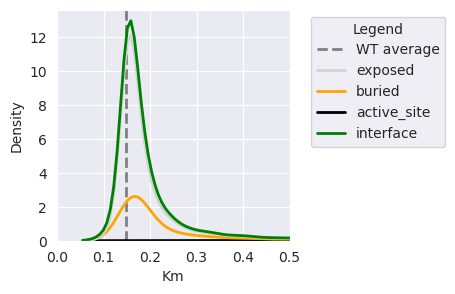

In [37]:
# Histogram by position type (interface, active site, etc.)
%matplotlib inline

residueTypeTable = pd.read_csv(RESIDUE_TYPE_DATA)
# KmVmaxData = pd.read_csv('/Users/noamprywes/Google_Drive/Lab_notebooks/IGI/NP-11-Rr_library/Latest Luke data/2024_01_30_bootstrap_Kms_Vmax.csv')
KmVmaxData = KmVmaxData.merge(residueTypeTable, on = 'mutant')
KmVmaxData = KmVmaxData[KmVmaxData['Km_qbcov'] < 1]

# Define custom palette
custom_palette = {'exposed': 'lightgrey', 'buried': 'orange',
                  'active_site': 'black', 'interface': 'green'}

# Plot vertical lines
plt.axvline(x=0.149, color='grey', linestyle='--', linewidth=2, label='WT average')

# Plot KDE plot
sns.kdeplot(data=KmVmaxData,
            x='Km_median',
            hue='label',
            fill=False,
            linewidth=2,
            palette=custom_palette,
            alpha=1,
            multiple="stack")

# Set labels and title
plt.xlabel('Km')
plt.ylabel('Density')

# Create custom legend handles and labels
legend_handles = [Line2D([0], [0], color='grey', linestyle='--', linewidth=2),
#                   Line2D([0], [0], color='red', linestyle='--', linewidth=2)
                 ]

legend_labels = ['WT average']

# Add KDE legend handles and labels
for label, color in custom_palette.items():
    legend_handles.append(Line2D([0], [0], color=color, linewidth=2))
    legend_labels.append(label)

# Create legend for all elements
plt.legend(legend_handles, legend_labels, loc='upper right', bbox_to_anchor=(1.7, 1), title='Legend')

plt.xlim(0,0.5)

# Save and show the plot
plt.savefig(OUTPUT_FIGURE_PATH + 'Fig4KmHist.svg', format='svg')
plt.show()


findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: 

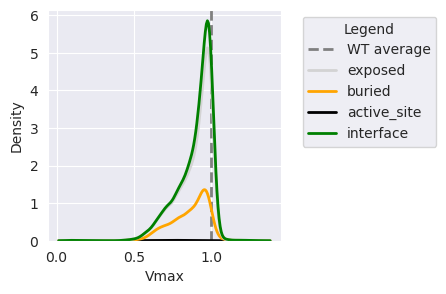

In [38]:
# Histogram by position type (interface, active site, etc.)
%matplotlib inline

# Define custom palette
custom_palette = {'exposed': 'lightgrey', 'buried': 'orange',
                  'active_site': 'black', 'interface': 'green'}

# Plot vertical lines
plt.axvline(x=1, color='grey', linestyle='--', linewidth=2, label='WT average')

# Plot KDE plot
sns.kdeplot(data=KmVmaxData,
            x='Vmax_median',
            hue='label',
            fill=False,
            linewidth=2,
            palette=custom_palette,
            alpha=1,
            multiple="stack")

# Set labels and title
plt.xlabel('Vmax')
plt.ylabel('Density')

# Create custom legend handles and labels
legend_handles = [Line2D([0], [0], color='grey', linestyle='--', linewidth=2),
#                   Line2D([0], [0], color='red', linestyle='--', linewidth=2)
                 ]

legend_labels = ['WT average']

# Add KDE legend handles and labels
for label, color in custom_palette.items():
    legend_handles.append(Line2D([0], [0], color=color, linewidth=2))
    legend_labels.append(label)

# Create legend for all elements
plt.legend(legend_handles, legend_labels, loc='upper right', bbox_to_anchor=(1.7, 1), title='Legend')

# plt.xlim(0,0.5)

# Save and show the plot
plt.savefig(OUTPUT_FIGURE_PATH + 'Fig4VmaxHist.svg', format='svg')
plt.show()


findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family ['helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not 

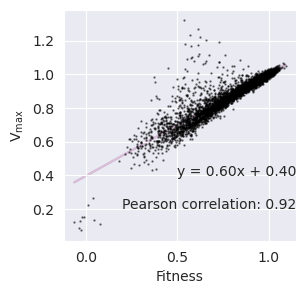

In [39]:
#Fitness vs. Vmax

plt.scatter(KmVmaxData['mean_enrich'], KmVmaxData['Vmax_median'], s = 0.5, color = 'black', alpha = 0.5)
plt.xlabel('Fitness')
plt.ylabel('V$_{\mathrm{max}}$')

#find line of best fit
a, b = np.polyfit(KmVmaxData['mean_enrich'], KmVmaxData['Vmax_median'], 1)

#add line of best fit to plot
plt.plot(KmVmaxData['mean_enrich'],
         a*KmVmaxData['mean_enrich']+b,
         color = 'thistle', zorder = 0)

plt.text(0.5, 0.4, 'y = ' + '{:.2f}'.format(a) + 'x + ' + '{:.2f}'.format(b))
plt.text(0.2, 0.2, 'Pearson correlation: ' + str(pearsonr(KmVmaxData['mean_enrich'],
                                                        KmVmaxData['Vmax_median'])[0])[:4])
plt.savefig('S16D.svg')

plt.show()

findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: 

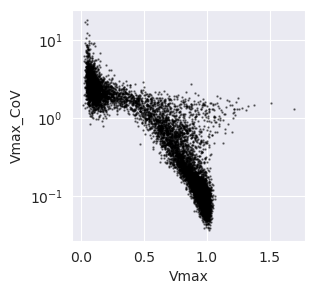

In [47]:
# Vmax vs. Km CV

residueTypeTable = pd.read_csv(RESIDUE_TYPE_DATA)
KmVmaxDataChimera = pd.read_csv(KM_BOOTSTRAP_DATA)
KmVmaxDataChimera = KmVmaxDataChimera.merge(residueTypeTable, on = 'mutant')

plt.scatter(KmVmaxDataChimera['Vmax_median'], KmVmaxDataChimera['Km_qbcov'], s = 0.5, color = 'black', alpha = 0.5)
plt.xlabel('Vmax')
plt.ylabel('Vmax_CoV')
plt.yscale('log')
plt.savefig('S16B.svg')

plt.show()

findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.


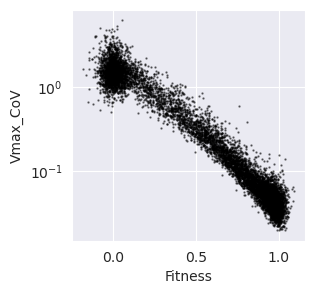

In [48]:
# fitness vs. Vmax_CV

plt.scatter(KmVmaxDataChimera['mean_enrich'], KmVmaxDataChimera['Vmax_qbcov'], s = 0.5, color = 'black', alpha = 0.5)
plt.xlabel('Fitness')
plt.ylabel('Vmax_CoV')
plt.yscale('log')


plt.show()

findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: 

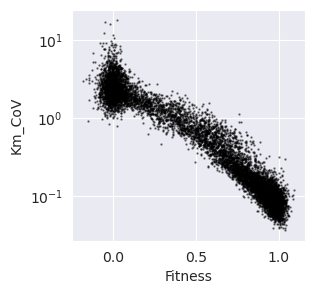

In [49]:
# fitness vs. Km_CV

plt.scatter(KmVmaxDataChimera['mean_enrich'], KmVmaxDataChimera['Km_qbcov'], s = 0.5, color = 'black', alpha = 0.5)
plt.xlabel('Fitness')
plt.ylabel('Km_CoV')
plt.yscale('log')
plt.savefig('S16A.svg')


plt.show()

findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.


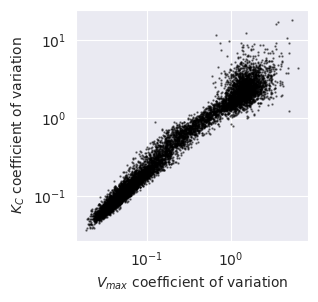

In [50]:
# Vmax_CV vs. Km_CV

plt.scatter(KmVmaxDataChimera['Vmax_qbcov'], KmVmaxDataChimera['Km_qbcov'], s = 0.5, color = 'black', alpha = 0.5)
plt.xlabel('$V_{max}$ coefficient of variation')
plt.ylabel('$K_{C}$ coefficient of variation')
plt.yscale('log')
plt.xscale('log')
plt.savefig('S16C.svg')

plt.show()

In [51]:

positionSpreads = pivotAA_Pos.max(axis = 0) - pivotAA_Pos.min(axis = 0)

positionSpreads.iloc[:458]

dataForChimera = pd.DataFrame(positionSpreads.iloc[:458]).dropna().reset_index().rename(columns = {0:'Km'})
dataForChimera = dataForChimera[dataForChimera['position'] < 460]
dataForChimera['extraTab'] = ''
dataForChimera['AApos'] = ':' + dataForChimera['position'].astype('str')
chimeraFile = OUTPUT_FIGURE_PATH + 'KmMediansSpread040524.defattr'
dataForChimera[['extraTab', 'AApos', 'Km']].to_csv(chimeraFile,
                                                           index = False,
                                                           header = False,
                                                           sep='\t')

# Open the file in read mode and read its contents
with open(chimeraFile, 'r') as file:
    original_content = file.read()
# Open the file in write mode
with open(chimeraFile, 'w') as file:
    # Write the additional text at the beginning
    additional_text = "attribute: KmSpreads\nmatch mode: non-zero\nrecipient: residues\n"
    file.write(additional_text)
    file.write(original_content)

## TESTED UNTIL THIS CELL
### KEEP PROBING THE NOTEBOOK FROM HERE

In [53]:
# Final figure with Avi data

# Load the data from Excel, remove data points that are not comparable.
# raw_kin_df is everything in the file, kin_df is the subset with all relevant kinetic data.
raw_kin_df, kin_df = load_rubisco_data(RUBISCO_KINETICS_DATA)

# Subset the data in various ways for future use
raw_kin_df, savir_df, nonsavir_df = filter_data(raw_kin_df)

# Merge multiple measurements of the same organism by taking the median value.
merged_kin_df = merge_organisms(raw_kin_df)

merged_kin_df['efficiency'] = merged_kin_df['vC']/merged_kin_df['KC']

# Group by RuBisCO form
grouped_form = merged_kin_df.groupby('isoform')

# Markers we use for plotting below.
markers = 'o><^dsphH*'

cnames = ["windows blue", "amber", "greyish brown", "dusty purple", "dusty teal", "dusty red", ]
named_colors = sns.xkcd_palette(cnames)


FileNotFoundError: [Errno 2] No such file or directory: '../data/DatasetS2_RubiscoKinetics_Merged.csv'

In [14]:
# Categories used to color enzymes by the physiology of their host organisms. Purpose
# of this is to highlight the steroetyped variation in SC/O. 

# Note: it's challenging to come up with a uniform taxonomy for autotrophs because the
# important physiological characteristics (e.g. C4, CAM, carboxysome CCMs) are polyphyletic.
# The ad-hoc taxonomy in our supplementary file could probably be improved. However, for
# the purposes of this work, we "lump" together some of the groups for which there is
# limited data - groups like heterokonts and haptophytes, which are phylogenetically disparate
# algae for which we have limited Rubisco data. 

group_mapping = {'C3 plants': 'C3 plants',
                 'C3-C4 plants': 'Other Form I',
                 'Cyanobacteria': 'Cyanobacteria',
                 'C4 plants': 'C4 plants',
                 'Gymnosperm': 'Other Form I',
                 'Basal angiosperm': 'Other Form I',
                 'Carnivorous plants': 'Other Form I',
                 'Bryophyte': 'Other Form I',
                 'CAM plants': 'Other Form I',
                 'Green algae': 'Other Form I',
                 'Diatoms': 'Other Form I',
                 'Chromophyte algae': 'Other Form I',
                 'Haptophyte algae': 'Other Form I',
                 'Rhodophyte algae': 'Other Form I',
                 'Macroalgae': 'Other Form I',
                 'Red algae': 'Red algae',
                 'Alphaproteobacteria': 'Other Form I',
                 'Betaproteobacteria': 'Other Form I',
                 'Gammaproteobacteria': 'Other Form I',
                }


group_mapping_noam = {'C3 plants': 'Plants',
                 'C3-C4 plants': 'Plants',
                 'Cyanobacteria': 'Cyanobacteria',
                 'C4 plants': 'Plants',
                 'C4-like plants': 'Plants',
                 'Gymnosperm': 'Plants',
                 'Basal angiosperm': 'Plants',
                 'Carnivorous plants': 'Plants',
                 'Fern': 'Plants',
                 'Bryophyte': 'Plants',
                 'CAM plants': 'Plants',
                 'Green algae': 'Algae',
                 'Diatoms': 'Algae',
                 'Chromophyte algae': 'Algae',
                 'Haptophyte algae': 'Algae',
                 'Rhodophyte algae': 'Algae',
                 'Macroalgae': 'Algae',
                 'Red algae': 'Algae',
                 'Alphaproteobacteria': 'Other Bacteria',
                 'Betaproteobacteria': 'Other Bacteria',
                 'Gammaproteobacteria': 'Other Bacteria',
                }

color_mapping = {
    'C3-C4 plants': 'very light brown',
    'C4 plants': 'pea soup',
    'C3 plants': 'dusty green',
    'Other plants': 'grey/green',
    'Cyanobacteria': 'dark blue green',
    'Green algae': 'dusty teal',
    'Red algae': 'dusty pink',
    'Diatoms': 'gunmetal',
    'Other algae': 'muddy brown',
    'Proteobacterial FI': 'dusty rose',
    'Other Form I': 'grey',
}

color_mapping_noam = {
    'Plants': 'dusty green',
    'Cyanobacteria': 'bright blue',
    'Algae': 'brown green',
    'Other Bacteria': 'dusty rose',
    '2' : 'magenta',
    '2_3' : 'purple',
    '3' : 'blue',
        'Form II' : 'magenta',
    'Form II/III' : 'purple',
    'Form III' : 'blue',
    
}

fancy_labels = {
    'C3-C4 plants': '$C_3$-$C_4$ plants',
    'C4 plants': '$C_4$ plants',
    'C3 plants': '$C_3$ plants',
}
label2color = dict((fancy_labels.get(k, k), sns.xkcd_rgb[color_mapping.get(k)])
                   for k in color_mapping.keys())

F1_data = merged_kin_df[merged_kin_df.isoform == '1']
F2_data = merged_kin_df[merged_kin_df.isoform == '2']
grouped_taxa = F1_data.set_index('taxonomy').groupby(group_mapping_noam)

# Order of plotting sets order of legend.
plotting_order = ['C3 plants', 'C4 plants', 'Red algae', 'Cyanobacteria', 'Other Form I']
# These groups have enough data for histograms to be plotted.
hist_groups = ['C4 plants', 'C3 plants', 'Cyanobacteria', 'Red algae', ]
hist_groups_noam = color_mapping_noam.keys()

In [15]:
# Savir 2010 focuses on kcat,C vs KC. Panel B investigates this 
vCs = np.log(merged_kin_df.vC)
KCs = np.log(merged_kin_df.KC)

print('Whole dataset correlation')
r, p = power_laws.log_pearsonr(KCs, vCs)
print('Log-scale linear regression R = %.2f, P = %.2g' % (r, p))
print('Spearman rank correlation R = %.2f, P = %.2g' % power_laws.log_spearmanr(KCs, vCs))
print()

fIs = merged_kin_df[merged_kin_df.isoform == '1']
vCs = np.log(fIs.vC)
KCs = np.log(fIs.KC)

print('FI subset')
r, p = power_laws.log_pearsonr(KCs, vCs)
print('Log-scale linear regression R = %.2f, P = %.2g' % (r, p))
print('Spearman rank correlation R = %.2f, P = %.2g' % power_laws.log_spearmanr(KCs, vCs))
print()

vCs = np.log(savir_df.vC)
KCs = np.log(savir_df.KC)

print('Savir subset')
r, p = power_laws.log_pearsonr(KCs, vCs)
print('Log-scale linear regression R = %.2f, P = %.2g' % (r, p))
print('Spearman rank correlation R = %.2f, P = %.2g' % power_laws.log_spearmanr(KCs, vCs))

Whole dataset correlation
Log-scale linear regression R = 0.35, P = 2e-08
Spearman rank correlation R = 0.44, P = 6.1e-13

FI subset
Log-scale linear regression R = 0.48, P = 3.4e-15
Spearman rank correlation R = 0.48, P = 3.2e-15

Savir subset
Log-scale linear regression R = 0.92, P = 2.9e-08
Spearman rank correlation R = 0.86, P = 2e-06


In [16]:
# Naive fit of the FI subset of the dataset.
# kcat,C vs KC correlation for all data rubiscos
KCs = np.log(F1_data.KC)
vCs = np.log(F1_data.vC)
exponent, prefactor, r = power_laws.fit_power_law_odr(KCs, vCs)

# kcat,C vs KC correlation for all data rubiscos
KCs_savir = np.log(savir_df.KC)
vCs_savir = np.log(savir_df.vC)
exp_sav, pre_sav, r_sav = power_laws.fit_power_law_odr(KCs_savir, vCs_savir)

Bootstrapping FI fits
95% CI for log-scale Pearson R (0.27, 0.66)
95% CI for power law exponent (0.25, 0.50)
95% CI on power law prefactor (0.79, 1.55)


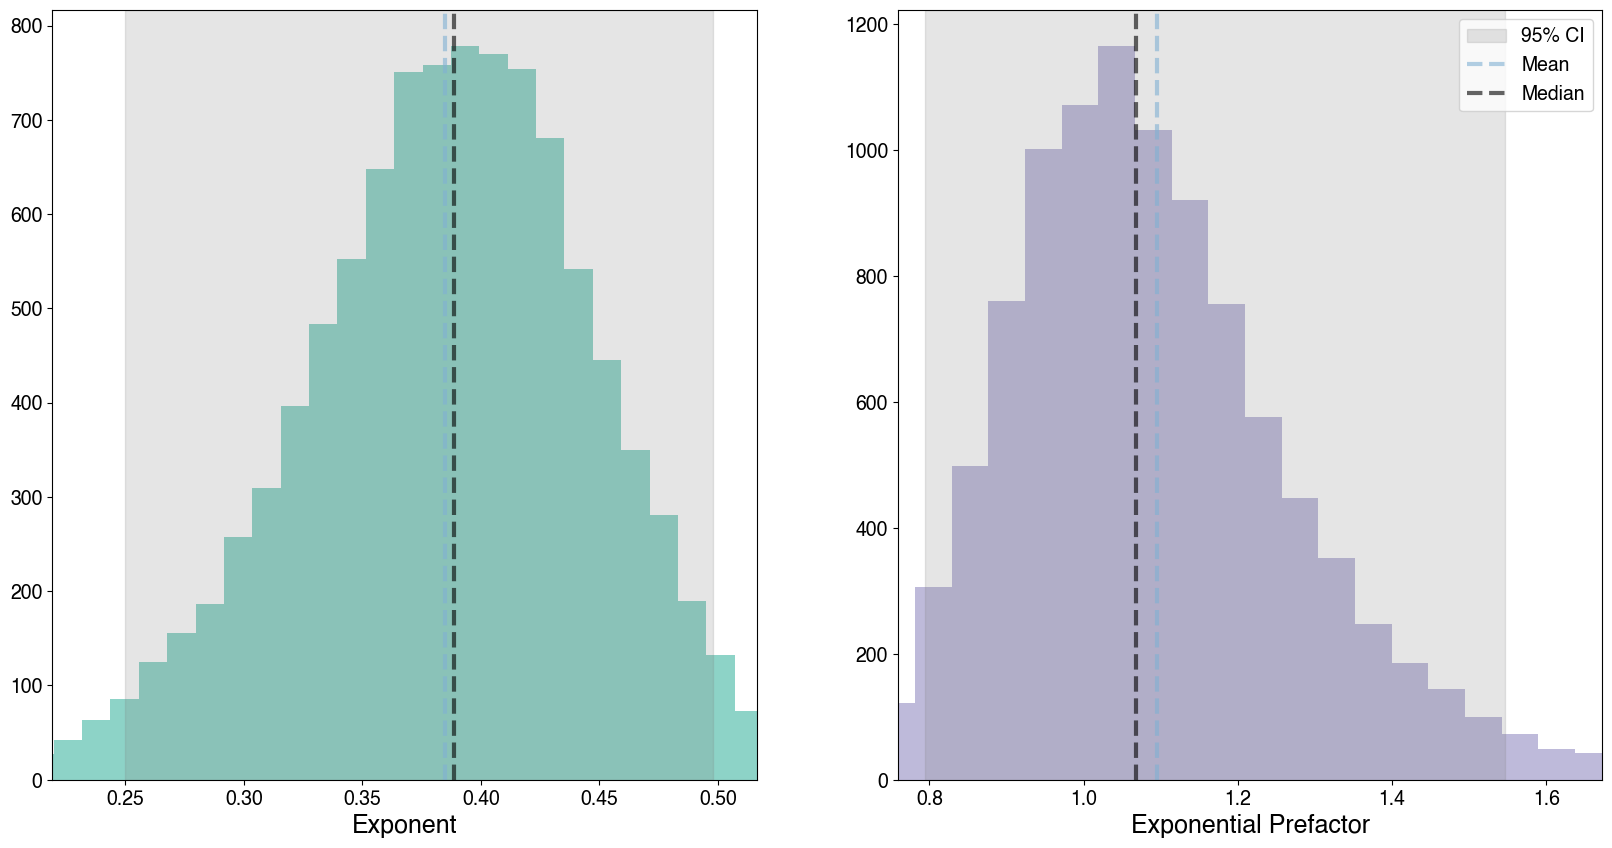

In [17]:
# Bootstrapped TLS fitting of kcat,C vs KC over the Form I data to calculate 95% CIs.
exps, pres, rs = power_laws.bootstrap_power_law_odr(
    F1_data.KC, F1_data.vC, fraction=0.9, rounds=10000)

conf_range = [2.5, 97.5]  # middle 95%
pre_low, pre_high = np.percentile(pres, conf_range)
exp_low, exp_high = np.percentile(exps, conf_range)
r_low, r_high = np.percentile(rs, conf_range)

print('Bootstrapping FI fits')
print('95%% CI for log-scale Pearson R (%.2f, %.2f)' % (r_low, r_high))
print('95%% CI for power law exponent (%.2f, %.2f)' % (exp_low, exp_high))
print('95%% CI on power law prefactor (%.2f, %.2f)' % (pre_low, pre_high))

# Uncomment to look at the distributions. 
power_laws.plot_bootstrapped_range(exps, pres)

In [18]:
# Combine all data so that it all plots together

# Get new Davidi data

davidiData = pd.read_csv('formIIOliverData.csv')
davidiDataFII = davidiData[davidiData['Form'] == 2]
davidiDataFII['Form'] = davidiDataFII['Form'].astype(str)

# Put in Candace data

# candaceData = {'species' : ['R. rubrum'   , 'V266T', 'A102Y', 'Km12'],
#                'vC'      : [9.92573   , 4.95   , 1.60   , 2.11],
#                'KC'      : [120.56 , 61.12  , 34.88  , 49.55],
#                'kcatErr' : [0.367  , 0.117  , 0.048  , 0.0603],
#                'KmErr'   : [7.89   , 5.10   , 3.25   , 3.23],
#                'mutant'  : [0, 1,1,1],
#                # Keep rubrum separate to be plotted on its own
#                'isoform': [0,0,0,0]}
# candaceDF = pd.DataFrame.from_dict(candaceData)
# candaceDF.to_csv('candaceData030124.csv')
candaceDF = pd.read_csv('in vitro data summary.csv')
candaceDF = candaceDF.dropna(subset = ['Oliver Kc'])[['Mutation', 'Oliver Kc', 'Oliver Kc error',
                                                         'Oliver kcat', 'Oliver kcat error']]
candaceDF = candaceDF.rename(columns = {'Mutation':'species', 'Oliver Kc':'KC', 'Oliver Kc error':'KmErr',
                                                         'Oliver kcat':'vC', 'Oliver kcat error':'kcatErr'})
candaceDF['mutant'] = [0,1,1,1]
candaceDF['isoform'] = [0,0,0,0]
candaceDF.to_csv('candaceData040524.csv')

F3_data = merged_kin_df[merged_kin_df.isoform == '3']
# Add R. palustris data back in left out by Avi
palustrisData = {'species' : ['Rhodopsedomonas palustris'],
               'vC'   : [4.9],
               'KC'     : [104],
               'kcatErr': [0.2],
               'KmErr'  : [22],
                'S'     :  [12],
                'isoform': ['2']}
palustrisDF = pd.DataFrame.from_dict(palustrisData)
# F2_data_palustris = pd.concat([F2_data, palustrisDF], ignore_index=True)
# F2_data_palustris = F2_data_palustris[F2_data_palustris['species'] != 'Rhodospirillum rubrum']

davidiDataFIIforPlot = davidiDataFII.rename(columns = {'Organism':'species', 'Form':'isoform',
                                            'KM [µM]':'KC', 'kcat [s-1]':'vC', 'Sc/o':'S'})

allBiochem = pd.concat([F2_data, palustrisDF], ignore_index=True)
allBiochem = pd.concat([merged_kin_df, allBiochem], ignore_index=True)
allBiochem = pd.concat([allBiochem, F3_data], ignore_index=True)
allBiochem = pd.concat([allBiochem, candaceDF], ignore_index=True)
allBiochem = pd.concat([allBiochem, davidiDataFIIforPlot], ignore_index=True)
allBiochem['noamTax'] = allBiochem['taxonomy'].map(group_mapping_noam)
allBiochem['noamTax'] = allBiochem['noamTax'].fillna(allBiochem['isoform'])

# Your dictionary for replacement
replacement_dict = {
    '2': 'Form II',
    '3': 'Form III',
    '2_3': 'Form II/III',
}

# Replace values in the 'Column_Name' column using the dictionary
allBiochem['noamTax'] = allBiochem['noamTax'].replace(replacement_dict)
allBiochem['isoform'] = allBiochem['isoform'].replace(replacement_dict)

allBiochem

,species,mutant,isoform,taxonomy,KC,vC,S,KO,KRuBP,vO,kon_C,kon_O,efficiency,kcatErr,KmErr,Oligomeric state,kcat/KM [s-1/mM],Rate spec assay (mean; s-1),Identifier,noamTax
0,Acidithiobacillus ferrooxidans,0.0,1,Gammaproteobacteria,81.0,6.80,NaN,NaN,NaN,NaN,0.0839,NaN,0.083951,NaN,NaN,NaN,NaN,NaN,NaN,Other Bacteria
1,Aegilops biuncialis,0.0,1,C3 plants,16.8,3.20,96.3,470.0,NaN,0.930,0.1900,0.00198,0.190476,NaN,NaN,NaN,NaN,NaN,NaN,Plants
2,Aegilops comosa,0.0,1,C3 plants,13.5,2.86,106.0,360.0,NaN,0.720,0.2120,0.00201,0.211852,NaN,NaN,NaN,NaN,NaN,NaN,Plants
3,Aegilops cylindrica,0.0,1,C3 plants,13.7,3.68,109.0,451.0,NaN,1.110,0.2680,0.00247,0.268613,NaN,NaN,NaN,NaN,NaN,NaN,Plants
4,Aegilops juvenalis,0.0,1,C3 plants,20.6,3.25,90.4,492.0,NaN,0.859,0.1580,0.00175,0.157767,NaN,NaN,NaN,NaN,NaN,NaN,Plants
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316,H. marinus,NaN,Form II,NaN,184.0,24.40,20.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L2,0.132609,11.3,WP_029912625.1,Form II
317,S. caldicuralii,NaN,Form II,NaN,144.0,20.50,13.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L4,0.142361,9.7,WP_074200542.1,Form II
318,Unknown organism,NaN,Form II,NaN,170.0,20.00,4.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L6,0.117647,11.7,WP_052580230.1,Form II
319,Zetaproteobacteria_53_45,NaN,Form II,NaN,286.0,26.30,13.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L2,0.091958,13.1,cg1_0.2_scaffold_4987_c_3,Form II


In [46]:
PlantAlgaeMinKC = allBiochem[(allBiochem['taxonomy'] != 'Cyanobacteria') & 
           (allBiochem['taxonomy'] != 'Alphaproteobacteria') & 
           (allBiochem['taxonomy'] != 'Betaproteobacteria') & 
           (allBiochem['taxonomy'] != 'Gammaproteobacteria') & 
          (allBiochem['isoform'] == '1')]['KC'].min()

PlantAlgaeMaxKC = allBiochem[(allBiochem['taxonomy'] != 'Cyanobacteria') & 
           (allBiochem['taxonomy'] != 'Alphaproteobacteria') & 
           (allBiochem['taxonomy'] != 'Betaproteobacteria') & 
           (allBiochem['taxonomy'] != 'Gammaproteobacteria') & 
          (allBiochem['isoform'] == '1')]['KC'].max()

FIIMinKC = allBiochem[(allBiochem['isoform'] == 'Form II')]['KC'].min()

FIIMaxKC = allBiochem[(allBiochem['isoform'] == 'Form II')]['KC'].max()
FIIMaxKC

286.0

In [66]:
allBiochem[(allBiochem['isoform'] == 'Form II')]

,species,mutant,isoform,taxonomy,KC,vC,S,KO,KRuBP,vO,kon_C,kon_O,efficiency,kcatErr,KmErr,Oligomeric state,kcat/KM [s-1/mM],Rate spec assay (mean; s-1),Identifier,noamTax
236,Rhodobacter sphaeroides II,0.0,Form II,Alphaproteobacteria,80.0,NaN,9.00,220.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other Bacteria
237,Rhodospirillum rubrum,0.0,Form II,Alphaproteobacteria,84.0,7.3,11.75,406.0,17.5,2.235,0.0870,0.008305,0.086905,NaN,NaN,NaN,NaN,NaN,NaN,Other Bacteria
285,Thiobacillus denitrificans II,0.0,Form II,Betaproteobacteria,256.0,3.5,13.30,619.0,13.3,0.637,0.0136,0.001030,0.013672,NaN,NaN,NaN,NaN,NaN,NaN,Other Bacteria
305,Rhodobacter sphaeroides II,0.0,Form II,Alphaproteobacteria,80.0,NaN,9.00,220.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other Bacteria
306,Rhodospirillum rubrum,0.0,Form II,Alphaproteobacteria,84.0,7.3,11.75,406.0,17.5,2.235,0.0870,0.008305,0.086905,NaN,NaN,NaN,NaN,NaN,NaN,Other Bacteria
307,Thiobacillus denitrificans II,0.0,Form II,Betaproteobacteria,256.0,3.5,13.30,619.0,13.3,0.637,0.0136,0.001030,0.013672,NaN,NaN,NaN,NaN,NaN,NaN,Other Bacteria
308,Rhodopsedomonas palustris,NaN,Form II,NaN,104.0,4.9,12.00,NaN,NaN,NaN,NaN,NaN,NaN,0.2,22.0,NaN,NaN,NaN,NaN,Form II
314,Gallionella sp.,NaN,Form II,NaN,253.0,27.3,10.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L2,0.107905,12.2,OGS68397.1,Form II
315,Zetaproteobacterium,NaN,Form II,NaN,253.0,27.7,12.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L2,0.109486,12.7,cg1_0.2_scaffold_945_c_30,Form II
316,H. marinus,NaN,Form II,NaN,184.0,24.4,20.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L2,0.132609,11.3,WP_029912625.1,Form II


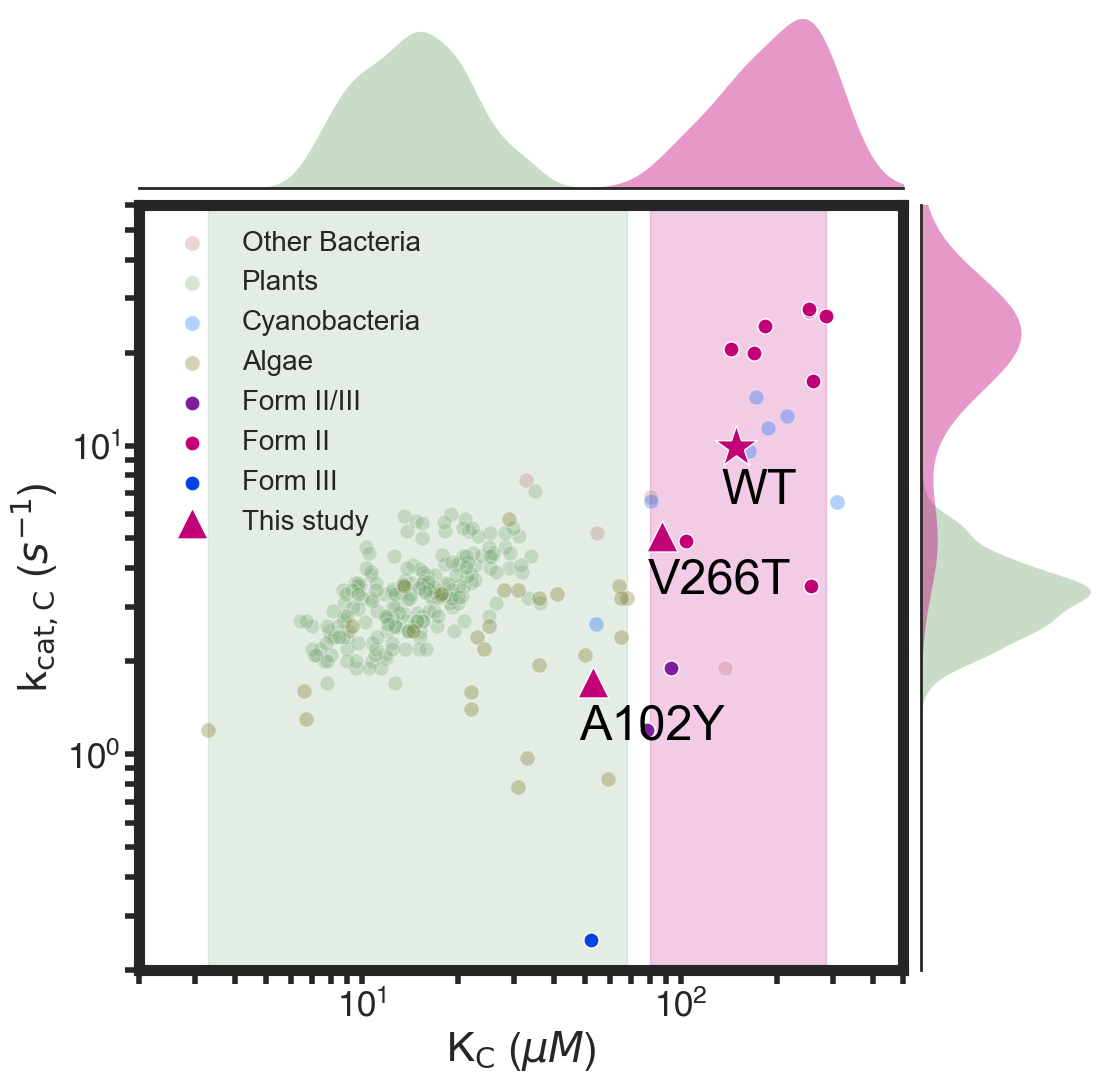

In [103]:
# Scatter plot of kcat,C vs KC colored by taxonomy with histograms

from matplotlib.patches import Rectangle

g = sns.JointGrid(x='S', y='vC', data=merged_kin_df, height=12, ratio=4)

sns.set_style('white')
g.ax_joint.set_xscale('log')
g.ax_joint.set_yscale('log')

g.ax_joint.set_xlim(2, 500)
g.ax_joint.set_ylim(2e-1, 60)

xvar, yvar = 'KC', 'vC'

# Plot FI data separately

uniqueLabels = set()
formI_data = allBiochem[allBiochem['isoform'] == '1']

# Group by taxa
grouped_taxa_fI = formI_data.groupby('noamTax')

# Clear existing histograms
g.ax_marg_x.clear()
g.ax_marg_y.clear()

# Define the order of colors for the unique values in the "noamTax" column
hue_order = allBiochem['noamTax'].unique()
hue_order = ['Plants',
#              'Algae',
             'Form II']

# Create a Seaborn color palette
custom_palette_hist = [sns.xkcd_rgb[color_mapping_noam[group]] for group in hue_order]

# Draw rectangles
rect1 = Rectangle((PlantAlgaeMinKC, 0.02), PlantAlgaeMaxKC-PlantAlgaeMinKC,
                  60, color=sns.xkcd_rgb['dusty green'],alpha=0.2)
rect2 = Rectangle((FIIMinKC, 0.02), FIIMaxKC-FIIMinKC, 60, color=sns.xkcd_rgb['magenta'], alpha=0.2)

# Add rectangles to the plot
g.ax_joint.add_patch(rect1)
g.ax_joint.add_patch(rect2)

# Create a kdeplot for x outside the loop
for group in hue_order:
    gdf = allBiochem[allBiochem['noamTax'] == group]
    cname = color_mapping_noam[group]
    c = sns.xkcd_rgb[cname]
    sns.kdeplot(data=gdf, x=xvar, color=c, ax=g.ax_marg_x, fill=True, alpha=0.4, label=group,
               linewidth = 0)

# Create a kdeplot for y outside the loop
for group in hue_order:
    gdf = allBiochem[allBiochem['noamTax'] == group]
    cname = color_mapping_noam[group]
    c = sns.xkcd_rgb[cname]
    sns.kdeplot(data=gdf, y=yvar, color=c, ax=g.ax_marg_y, fill=True, alpha=0.4, label=group,
               linewidth = 0)

for i, group in enumerate(formI_data['noamTax'].unique()):
    gdf = grouped_taxa_fI.get_group(group)
    cname = color_mapping_noam[group]
    c = sns.xkcd_rgb[cname]
    nx = gdf[xvar].notnull().sum()
    ny = gdf[yvar].notnull().sum()
    if group not in uniqueLabels:
        uniqueLabels.add(group)
        g.ax_joint.scatter(gdf[xvar], gdf[yvar], s=120, c=c, edgecolors='w',
                           label=group,
                      alpha = 0.3)
    else:
                g.ax_joint.scatter(gdf[xvar], gdf[yvar], s=120, c=c, edgecolors='w',
                           label=None,
                      alpha = 0.4)
    if group not in hist_groups_noam:
        continue

# Group by rubisco form
# Plot non-FI data separately, exclude alternative rubrum measurement
otherFormsData = allBiochem[(allBiochem['isoform'] != '1') &
                            (allBiochem['species'] != 'Rhodospirillum rubrum')]
grouped_forms = otherFormsData.groupby('isoform')

for i, group in enumerate(otherFormsData['isoform'].unique()):
    if group == 0:
        continue
    else:
        gdf = grouped_forms.get_group(group)
        cname = color_mapping_noam[group]
        c = sns.xkcd_rgb[cname]
        nx = gdf[xvar].notnull().sum()
        ny = gdf[yvar].notnull().sum()
        g.ax_joint.scatter(gdf[xvar], gdf[yvar], s=120, c=c, edgecolors='w', label=group,
                          alpha = 1)
        if group not in hist_groups_noam:
            continue

# Plot our data - isoform is 0 for this
oliver_color = 'magenta'
c = sns.xkcd_rgb[oliver_color]
g.ax_joint.scatter(candaceDF[(candaceDF['species'] != 'WT') &
                            (candaceDF['species'] != 'Km12')]['KC'],
                   candaceDF[(candaceDF['species'] != 'WT') &
                            (candaceDF['species'] != 'Km12')]['vC'], c=c, s=500, edgecolors='w',marker='^',
                   label='This study')

g.ax_joint.scatter(candaceDF[candaceDF['species'] == 'WT']['KC'],
                   candaceDF[candaceDF['species'] == 'WT']['vC'], c=c, s=1000, edgecolors='w',marker='*',
                   label=None)

# g.ax_joint.errorbar(candaceDF['KC'], candaceDF['vC'],
#                     xerr = candaceDF['KmErr'], yerr = candaceDF['kcatErr'],
# #                    linewidth = 0,
#                     fmt = 'none', capsize = 5,
#                    ecolor = c)

# Label our data - isoform is 0 for this
candaceDF = allBiochem[allBiochem['isoform'] == 0]
for mutant in candaceDF['species']:
    x = float(candaceDF[candaceDF['species'] == mutant]['KC'])
    y = float(candaceDF[candaceDF['species'] == mutant]['vC'])
    if mutant != 'Km12':
        g.ax_joint.text(0.9*x, 0.65*y, mutant, fontsize=35, color = 'black')
    else:
        pass
#         g.ax_joint.text(0.9*x, 0.75*y, 'K$_{\mathrm{M}}$12', fontsize=25, color = c)

# Plot the naive fit of the FI data. 
xs = np.arange(2, 500, 1)
ys = np.power(xs, exponent)*prefactor
# g.ax_joint.plot(xs, ys, color='grey', ls='--', lw=4)

g.ax_joint.set_xlabel('K$_{\mathrm{C}}$ ($\mu M$)', fontsize=30)
g.ax_joint.set_ylabel('k$_{\mathrm{cat,C}}$ ($s^{-1}$)', fontsize=30)
g.ax_joint.tick_params(labelsize=25)
# g.ax_joint.text(0.02, 0.02, '$CI_{95}$ for R = (%.2f, %.2f)' % (r_low, r_high), 
#                 transform=g.ax_joint.transAxes, fontsize=18)

for spine in g.ax_joint.spines.values():
    spine.set_linewidth(8)    
    # Adjust the spines of the axes
g.ax_joint.spines['right'].set_visible(True)
g.ax_joint.spines['top'].set_visible(True)

for spine in g.ax_marg_x.spines.values():
    spine.set_linewidth(2)
for spine in g.ax_marg_y.spines.values():
    spine.set_linewidth(2)
    
g.ax_joint.legend(ncol=1, loc = 2, fontsize=20, frameon = False)
plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'

# Remove x-axis and y-axis labels from histograms
g.ax_marg_x.set_xlabel('')
g.ax_marg_x.set_ylabel('')
g.ax_marg_y.set_ylabel('')
g.ax_marg_y.set_xlabel('')
# Remove x-axis and y-axis ticks from histograms
g.ax_marg_x.tick_params(axis='both', which='both', bottom=False,
                        top=False, labelbottom=False, left=False,
                        right=False, labelleft=False, labelright=False)
g.ax_marg_y.tick_params(axis='both', which='both', bottom=False,
                        top=False, labelbottom=False, left=False,
                        right=False, labelleft=False, labelright=False)

# # Set x-axis ticks manually
g.ax_joint.set_xscale('log')
g.ax_joint.tick_params(axis='both', which='both',left = True, bottom = True, width = 4, length = 10)
# g.ax_joint.set_xticks([10, 100])

# # Set y-axis ticks manually
g.ax_joint.set_yscale('log')
# g.ax_joint.set_yticks([1, 10])

# Adjust the layout to bring the histograms closer to the scatter plot
g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.1, hspace=0.1)

plt.savefig(OUTPUT_FIGURE_PATH + 'summaryFig040724.svg', dpi=600)
plt.show()

In [20]:
from biopandas.pdb import PandasPdb
from scipy.spatial import distance_matrix
# read in dataframe with structure classes by position
reslabel = pd.read_csv('2023_09_20_class_label.csv', index_col='position')
# read in the bootstrap fit data
df = pd.read_csv('2024_03_18_bootstrap_update_kH.csv', index_col='mutant',
                 usecols=['mutant','Km_median','Km_qbcov'])

df = df.drop('WT', axis=0)
# include a positions columns
positions = [int(mut[1:-1]) for mut in df.index]
df['positions'] = positions
# compute the median based effect size of the Km
df['Km_effect_size'] = (0.149 - df['Km_median']) / (df['Km_qbcov']*df['Km_median'])
# create a vectorized pointsize mapper
def point_size(K, minS, maxS, minK, maxK):
    m = (maxS - minS) / (minK - maxK)
    b = minS - maxK*m
    if K <= minK:
        S = maxS
    elif K > maxK:
        S = minS
    else:
        S = K*m + b
    return S

point_size_vect = np.vectorize(point_size)
# add structure class label to dataframe
df['label'] = reslabel.loc[df['positions']]['label'].to_numpy()


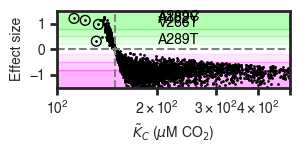

In [100]:


# Set font and figure parameters
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["figure.figsize"] = (3, 1)

plt.figure()

x = [100,500]
low = np.array([0.2,0.2])
mid = np.array([0.5,0.5])
hi = np.array([0.8,0.8])
max = np.array([1.5,1.5])

#plt.fill_between(x,-low, low, color='green', alpha = 0.2)
plt.fill_between(x,low, mid, color='#00FF00', alpha = 0.1)
plt.fill_between(x,mid, hi, color='#00FF00', alpha = 0.2)
plt.fill_between(x,hi, max, color='#00FF00', alpha = 0.3)
plt.fill_between(x,-mid, -low, color='#FF00FF', alpha = 0.1)
plt.fill_between(x,-hi, -mid, color='#FF00FF', alpha = 0.2)
plt.fill_between(x,-max, -hi, color='#FF00FF', alpha = 0.3)
plt.scatter(df[df['Km_qbcov'] < 1]['Km_median']*1000,
            df[df['Km_qbcov'] < 1]['Km_effect_size'], s=1, color='black')
plt.vlines(149, -1.5, 1.5, color = 'gray', linestyle = '--')
plt.hlines(0,100,500, color='gray', linestyle = '--')

bestKm = df[(df['Km_median'] < 0.9*0.149) & (df['Km_qbcov'] < 1)]

for row in bestKm.iterrows():
    plt.scatter(row[1]['Km_median']*1000, row[1]['Km_effect_size'], s = 50, marker = 'o', facecolors='none',
                edgecolors='black')
    plt.text(row[1]['Km_median'] + 200, row[1]['Km_effect_size'] -0.1, row[0], color='k')
    
# Make the plot frame thicker
for spine in plt.gca().spines.values():
    spine.set_linewidth(2)
    
    
plt.xlim([100,500])
plt.ylim([-1.5,1.5])
plt.xscale('log')
plt.xlabel('$\\tilde{K}_{C}$ ($\mu$M CO$_2$)')
plt.ylabel('Effect size')

plt.tick_params(axis='both', which='both', left = True, bottom = True, width=2, length = 5)


plt.savefig(OUTPUT_FIGURE_PATH + 'effectSize040724.svg', dpi=600, format='svg')
plt.show()

In [72]:
gdf = grouped_forms.get_group('Form II')

gdf[xvar]



236     80.0
285    256.0
305     80.0
307    256.0
308    104.0
314    253.0
315    253.0
316    184.0
317    144.0
318    170.0
319    286.0
320    260.0
Name: KC, dtype: float64

In [74]:
FIIMinKC

80.0